In this notebook, we compute the weight maps or phenotypes by fitting the entire set of observations for scores in which stacking led to improvement in the prediction accuracies. 

R1: We need to take into account the interpretation of weights

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join as opj
import os
import sys
import matplotlib.pylab as plt
import h5py

#Sklearn stuff
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import mean_absolute_error, r2_score

from scipy.stats import ks_2samp

In [3]:
sys.path.append("/home/javi/Documentos/multimodal-cognition/")
from stacking import StackingLassoCV

In [4]:
sns.set(font="Arial")

In [5]:
RANDOM_STATE = 0

Load the data

In [7]:
f =  h5py.File(opj("../data", "final_data.hdf5"), "a")
YY_domain_cognition =  f['YY_domain_cognition'][:]
X_conn = f['connectome_features'][:]
X_surf = f['surface_features'][:]
X_thic = f['thickness_features'][:]
X_subv_old = f['sub_vols_features'][:]
X_locc = f['loc_conn_features'][:]
subjects = f['subjects'][:]
f.close()

In [8]:
#f =  h5py.File(opj("../data", "final_data.hdf5"), "r")

#YY_domain_cognition =  f['YY_domain_cognition'][:]

#list_X_sources = [f['connectome_features'][:], 
 #                 f['surface_features'][:],
  #                f['thickness_features'][:],
   #               f['sub_vols_features'][:],
    #              f['loc_conn_features'][:]
                 ]
#subjects = f['subjects'][:]
#f.close()

In [8]:
#age = pd.read_excel(opj(data_dir, "age.xlsx"))
#age = pd.merge(pd.DataFrame({'Subject': subjects}), age, on='Subject')['Age_in_Yrs'].values

#age_bin = np.digitize(age, np.quantile(age, q=np.arange(0.1, 1, 0.1)))

In [11]:
unrestricted_dat = pd.merge(pd.DataFrame({'Subject': subjects}),
                            pd.read_excel("../data/unrestricted_jraserod_8_16_2019_12_4_12.xlsx"),
                            on='Subject')

In [12]:
icv_var = unrestricted_dat.FS_IntraCranial_Vol.values

In [14]:
icv_var

(1029,)

In [9]:
# As we said, take cognitive scores where stacking improved
score_names = ['CogTotalComp_Unadj', 'CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 
                'DDisc_AUC_200', 'VSPLOT_TC']

modality_names = ['CONNECTOME', 'SURFACE', 'THICKNESS', 'SUB_VOLUMES', 'LOCAL_CONN']
n_scores = len(score_names) 
n_mods = len(modality_names)

In [11]:
def adjust_age_new(YY_train, YY_test, M_train, M_test):
    """
    
    """
    linReg = LinearRegression(fit_intercept=False) #We already have the intercept in M
    linReg.fit(M_train, YY_train)
    
    # Substract predicted values and add intercept to keep the intercept_ercept_e scale
    YY_train_adj = YY_train - linReg.predict(M_train) + linReg.coef_[:, 0]
    YY_test_adjusted = YY_test - linReg.predict(M_test) + linReg.coef_[:, 0]
    
    return YY_train_adj, YY_test_adjusted

In [12]:
# Create design matrix to adjust age
poly =  PolynomialFeatures(degree = 1) 
M = poly.fit_transform(age[:, np.newaxis])
YY_adj_age, _ = adjust_age_new(YY_domain_cognition, YY_domain_cognition, M, M)

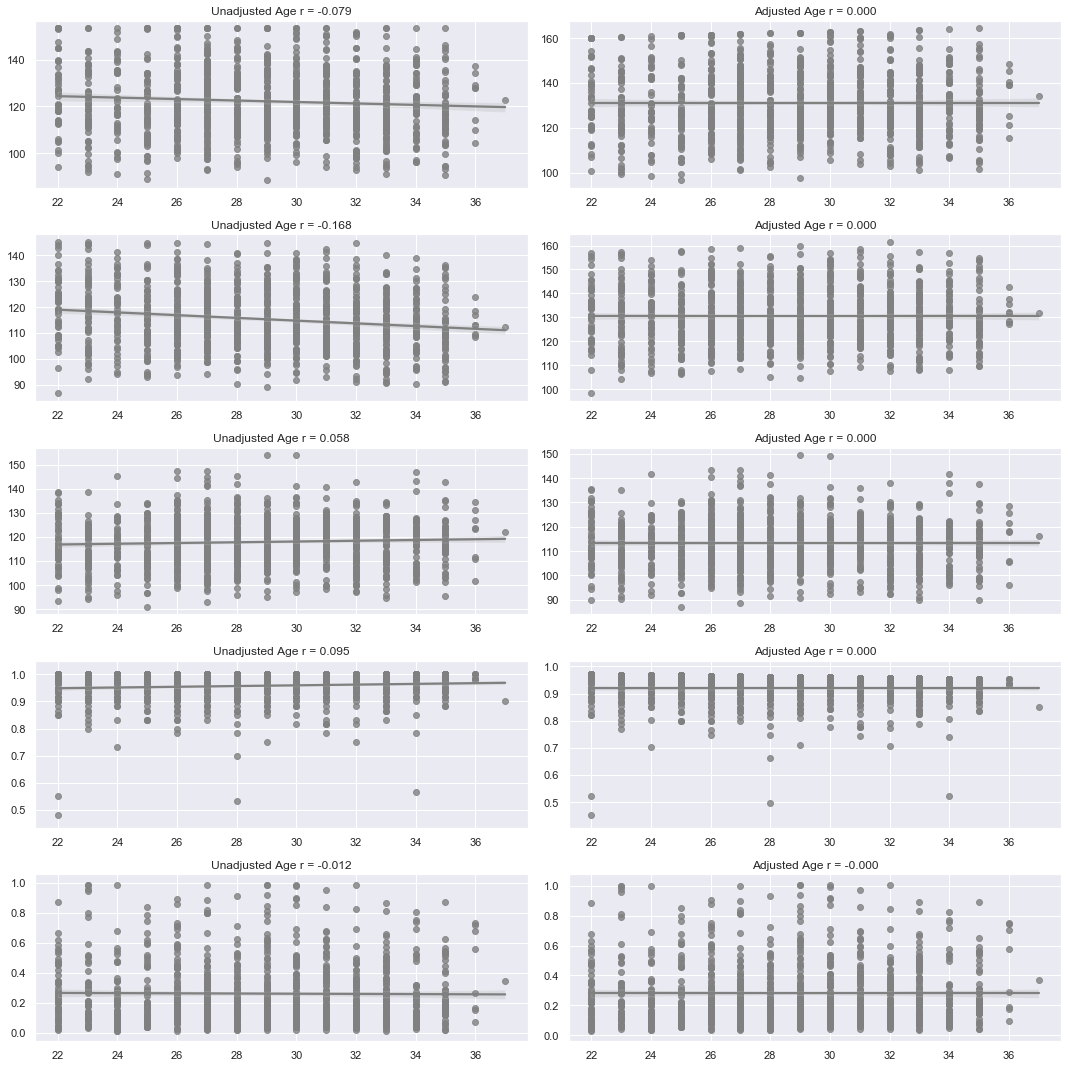

In [13]:
from scipy.stats import pearsonr
fig, axs = plt.subplots(ncols=2, nrows=n_scores, figsize=(15, 15))

for ii in range(n_scores):
    r, _ = pearsonr(age, YY_domain_cognition[:, ii])
    sns.regplot(age, YY_domain_cognition[:, ii], ax=axs[ii,0], color='grey')
    axs[ii, 0].set_title("Unadjusted Age r = %.3f" % r) 
    
    r, _ = pearsonr(age, YY_adj_age[:, ii])
    sns.regplot(age, YY_adj_age[:, ii], ax=axs[ii,1], color='grey')
    axs[ii, 1].set_title("Adjusted Age r = %.3f" % r)
    
plt.tight_layout()

In [61]:
import glob
#vol_measures = pd.read_csv(glob.glob(opj(data_dir, "final", "structural","*", "sub_volumes.txt"))[0], sep='\t').iloc[:,0].values

vt = VarianceThreshold()
vt.fit(list_X_sources[3])
#pd.DataFrame({'measure': vol_measures, 'included': vt.get_support()}).to_csv('../data/vol_features_support.csv', 
 #                                                                            sep='\t', index=False)

VarianceThreshold(threshold=0.0)

In [62]:
vt.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [22]:
[VarianceThreshold().fit_transform(X).shape[1] for X in list_X_sources]

[257403, 360, 360, 62, 128894]

In [10]:
score_names

['CogTotalComp_Unadj',
 'CogFluidComp_Unadj',
 'CogCrystalComp_Unadj',
 'DDisc_AUC_200',
 'VSPLOT_TC']

In [54]:
with h5py.File(opj("../results", "weights_phenotypes_R1.hdf5"), "a") as f:

    #save the phenotypes for each case
    for ii, score in zip([0,1,2,4,6], score_names):

        print("computing phenotypes for score {}".format(score))

        #create a group for this score
        f.create_group(score)

        prepend_transformation = [VarianceThreshold(), StandardScaler(), PCA()]
        stack_lasso = StackingLassoCV(prepend_transformation=prepend_transformation, cv=5,
                                      n_jobs=1, random_state = RANDOM_STATE)

        y = YY_adj_age[:, ii]

        print("first level fitting")
        
        #Fit stack lasso model
        stack_lasso.fit(list_X_sources, y)

        # Use fitted models to compute the phenotype and save to disk
        for jj, mod in enumerate(modality_names):
            
            # pca.components == V^T in the paper, with dims comps x features
            # beta is comps
            # then, we have to multiply beta x pca.components here
            # In the paper w = V x beta, but this is for column vectors
            # for a row vector w^T = V x beta^T, where V has dims features x comps
            phenotype = np.matmul(stack_lasso.estimators_[jj].coef_,
                                  stack_lasso.transformers_[jj].named_steps['pca'].components_)

            #Create a dataset for each modality in this group score
            f[score].create_dataset(mod, data=phenotype)

        print("second level fitting")
        clf_2 = LassoCV(cv=5, random_state=RANDOM_STATE, positive=True)

        #Fit on the stacked predictions
        clf_2.fit(stack_lasso.stacked_features_, y)

        # Save also the channel weights provided by lassso on the stacked predictions
        f[score].create_dataset('channel_weights', data = clf_2.coef_)

        print("finished\n")

computing phenotypes for score CogTotalComp_Unadj
first level fitting
second level fitting
finished

computing phenotypes for score CogFluidComp_Unadj
first level fitting
second level fitting
finished

computing phenotypes for score CogCrystalComp_Unadj
first level fitting
second level fitting
finished

computing phenotypes for score DDisc_AUC_200
first level fitting
second level fitting
finished

computing phenotypes for score VSPLOT_TC
first level fitting
second level fitting
finished



Our estimtator, before the PCA, it also performs a Variance threshold feauture selection, aiming at discarding those features whose variance is null across all the observations. This only happens to volume features. And this is something that we have to keep in mind when plotting the weight maps.

In [68]:
vt = VarianceThreshold()

for (mod, XX) in zip(modality_names, list_X_sources):
    vt.fit(XX)
    print("%s, number of original features = %d,"
          " number of features after Variance Threshold = %d" % (mod, XX.shape[1], sum(vt.get_support())))

CONNECTOME, number of original features = 257403, number of features after Variance Threshold = 257403
SURFACE, number of original features = 360, number of features after Variance Threshold = 360
THICKNESS, number of original features = 360, number of features after Variance Threshold = 360
SUB_VOLUMES, number of original features = 66, number of features after Variance Threshold = 62
LOCAL_CONN, number of original features = 128894, number of features after Variance Threshold = 128894


In [69]:
vol_measures = ['Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter',
                'Left-Cerebellum-Cortex','Left-Thalamus-Proper', 'Left-Caudate',
                'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle',
                '4th-Ventricle','Brain-Stem','Left-Hippocampus',
                'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 
                'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus',
                'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter',
                'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate',
                'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
                'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
                'Right-vessel', 'Right-choroid-plexus', '5th-Ventricle',
                'WM-hypointensities', 'Left-WM-hypointensities', 'Right-WM-hypointensities',
                'non-WM-hypointensities', 'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities',
                'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central',
                'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol',
                'BrainSegVolNotVent', 'BrainSegVolNotVentSurf','lhCortexVol',
                'rhCortexVol','CortexVol', 'lhCorticalWhiteMatterVol',
                'rhCorticalWhiteMatterVol', 'CorticalWhiteMatterVol', 'SubCortGrayVol',
                'TotalGrayVol', 'SupraTentorialVol', 'SupraTentorialVolNotVent',
                'SupraTentorialVolNotVentVox', 'MaskVol', 'BrainSegVol-to-eTIV',
                'MaskVol-to-eTIV', 'lhSurfaceHoles', 'rhSurfaceHoles',
                'SurfaceHoles','EstimatedTotalIntraCranialVol']

In [70]:
# Save which features are kept
vt = VarianceThreshold()
vt.fit(list_X_sources[3])
pd.DataFrame({'measure': vol_measures, 
              'included': vt.get_support()}).to_csv('../results/vol_features_support.csv', sep='\t', index=False)

In [73]:
# These are the omitted features
list(np.array(vol_measures)[~vt.get_support()])

['Left-WM-hypointensities',
 'Right-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'Right-non-WM-hypointensities']